**Date**: 2018-07-17

**Authors**: Yichen Fang

**Purpose**: To test whether shuffling the input improves the accuracy.

This notebook tests a naive alignment scheme that selects the first 1000 positions of a DNA sequence (add null positions to the end if a sequence is shorter than 1000). The sequences are shuffled before feeding into the neural network.

**Background**:
- The idea of this experiment is based on the understanding that any sequence bears more resemblance with its 23 'siblings' (which are next to each other in the list of sequences before shuffling). Without shuffling, either all siblings are in the training set, or all of them are in the validation set. By shuffling the sequences, all siblings would be randomly distributed into the training set and the validation set. We might be able to extract more information for a sequence based on those of its siblings that are distributed into the training set.

**Experiment**:

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

Load the `pickle` buffered list:

In [3]:
with open("../data/list_buffer.txt", "rb") as buff:
    seq_record_list = pickle.load(buff)

The following cell retains only 4800 sequences, for the purpose of testing speed. It also randomly shuffles the 4800 sequences.

In [24]:
seq_record_list = seq_record_list[:4800]
from random import shuffle
shuffle(seq_record_list)

The following cell transforms the data into a format that is recognizable by the neural network model.

In [13]:
# A helper function to flatten a 2d list to 1d.
# Input: [[1, 2], [2, 3], [3, 4, 5]]
# Output: [1, 2, 2, 3, 3, 4, 5]
def flatten(lst):
    new_lst = []
    for sub_lst in lst:
        for item in sub_lst:
            new_lst.append(item)
    return new_lst

# A helper function to transform a lst so that its length becomes read_len by:
# 1. If len(lst) > read_len, curtail the end of the lst.
# 2. If len(lst) < read_len, keep extending the end of the lst with 0 (NA).
def curtail(lst, read_len):
    if len(lst) > read_len:
        lst = lst[:read_len]
    else:
        for i in range(read_len - len(lst)):
            lst.append([0, 0, 0, 0, 0, 0, 0])
    return lst

# Produce the train-test split
# length_read: the length that you want all DNA sequences to conform to
def prepare_input(training_size, test_size, length_read):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    seq_count = 0
    while seq_count < training_size:
        X_train.append(flatten(curtail(seq_record_list[seq_count][3], length_read)))
        y_train.append(int(seq_record_list[seq_count][1]))
        seq_count += 1
    while seq_count < (training_size + test_size):
        X_test.append(flatten(curtail(seq_record_list[seq_count][3], length_read)))
        y_test.append(int(seq_record_list[seq_count][1]))
        seq_count += 1
    return X_train, y_train, X_test, y_test

# Turn list into numpy tensors that can directly feed into a neural network model
def to_np_array(X_train, y_train, X_test, y_test):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    if len(y_train.shape) == 1:
        y_train = np.transpose(np.array([y_train]))
    X_test = np.array(X_test)
    y_test = np.transpose(np.array(y_test))
    if len(y_test.shape) == 1:
        y_test = np.transpose(np.array([y_test]))
    return X_train, y_train, X_test, y_test

In [14]:
X_train, y_train, X_test, y_test = prepare_input(4320, 480, 1000)
X_train, y_train, X_test, y_test = to_np_array(X_train, y_train, X_test, y_test)
[X_train.shape, y_train.shape, X_test.shape, y_test.shape]

[(4320, 7000), (4320, 1), (480, 7000), (480, 1)]

The following cells build a recurrent network with four LSTM layers, with 8, 8, 4, 4 units respectively:

In [16]:
from keras.models import Model, Sequential
from keras.layers import Dense, CuDNNLSTM

In [18]:
X_train_rnn = X_train.reshape(4320, 1000, 7)

In [22]:
model = Sequential()
model.add(CuDNNLSTM(8, input_shape=(1000, 7), return_sequences=True))
model.add(CuDNNLSTM(8, return_sequences=True))
model.add(CuDNNLSTM(4, return_sequences=True))
model.add(CuDNNLSTM(4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_rnn, y_train, epochs=20, batch_size=128, validation_split=0.1)

Train on 3888 samples, validate on 432 samples
Epoch 1/20
3888/3888 [==============================] - 13s 3ms/step - loss: 0.6763 - acc: 0.5661 - val_loss: 0.6686 - val_acc: 0.5926
Epoch 2/20
3888/3888 [==============================] - 11s 3ms/step - loss: 0.6552 - acc: 0.5856 - val_loss: 0.6659 - val_acc: 0.5556
Epoch 3/20
3888/3888 [==============================] - 11s 3ms/step - loss: 0.6442 - acc: 0.6013 - val_loss: 0.6730 - val_acc: 0.5648
Epoch 4/20
3888/3888 [==============================] - 11s 3ms/step - loss: 0.6327 - acc: 0.6247 - val_loss: 0.6403 - val_acc: 0.6273
Epoch 5/20
3888/3888 [==============================] - 11s 3ms/step - loss: 0.6278 - acc: 0.6286 - val_loss: 0.6351 - val_acc: 0.6273
Epoch 6/20
3888/3888 [==============================] - 11s 3ms/step - loss: 0.6192 - acc: 0.6433 - val_loss: 0.6309 - val_acc: 0.6620
Epoch 7/20
3888/3888 [==============================] - 11s 3ms/step - loss: 0.6096 - acc: 0.6474 - val_loss: 0.6139 - val_acc: 0.6921
Epoch 8/

**Result**:

The following cell **visualize** the training/validation accuracies and losses over each epoch.

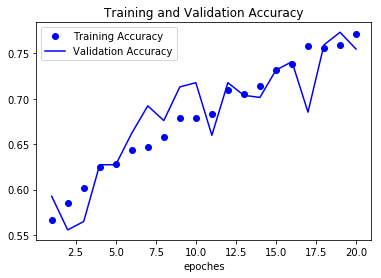

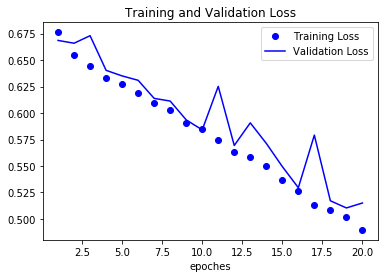

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoches')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoches')
plt.legend()

plt.show()

- The validation trend now follows closely to the training trend, and the correlation does not stop before 20 epoches, indicating that we might be able to achieve even better results if running for more than 20 epoches.

**Conclusion**:

- The result of the experiment proves my conjecture at the beginning.
- To summarize, for any sequence, its most resemblance sequences are its 23 ‘siblings’. If we don’t shuffle the data, either all 24 ‘siblings’ are in the training data, or all of them are in the validation data. By shuffling them, the 24 ‘siblings’ are randomly distributed into both training and validation data, allowing us to extracting more information.